# Imports

In [1]:
%matplotlib inline
%config IPCompleter.greedy = True
%config IPCompleter.merge_completions = True
%config IPCompleter.limit_to__all__ = False
import matplotlib
import numpy as np
from numpy import genfromtxt
import scipy.misc
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import csv
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation
from keras.regularizers import l2
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using gpu device 0: GeForce GTX 660M (CNMeM is disabled, cuDNN 5105)
Using Theano backend.


In [2]:
CHANNELS_NUM = 1
IMAGE_WIDTH = 48
IMAGE_HIGHT = 48
CLASSES_NUM = 7
EPOCHS_NUM = 80
BATCH_SIZE = 64
LEARNING_RATE = 0.001     #if from epoch 0, start with learning rate = 0.001
DATASET_SIZE = 35887
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
FILE_NAME = "fer2013/fer2013.csv"

# Data Loading

In [3]:
def load_data():

    X_data = np.zeros((DATASET_SIZE, IMAGE_HIGHT*IMAGE_WIDTH))
    Y_data = np.zeros((DATASET_SIZE,))
 
    i = 0
    with open(FILE_NAME, 'rb') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            X_data[i, :] = np.fromstring(row['pixels'], dtype=int, sep=' ')
            Y_data[i] = row['emotion']
            i = i + 1
            
    X_data = X_data.reshape((-1, CHANNELS_NUM, IMAGE_HIGHT, IMAGE_WIDTH))
    #print X_data.shape
    #print Y_data.shape
    
    #############################################
    #mask = np.random.choice(DATASET_SIZE, int((4.0/5)*DATASET_SIZE),replace = False)     #Random numbers must be unique.
   
    #Save the training data mask
    #output = open('TrainingDataMask.oo', 'wb')
    #pickle.dump(mask, output)
    #output.close()
    
    #Load the training data mask
    output = open('TrainingDataMask.oo', 'rb')
    mask = pickle.load(output)
    #############################################
    
    X_train = X_data[mask, :, :, :] 
    Y_train = Y_data[mask]
    X_val_tst = X_data[~mask, :, :, :] 
    Y_val_tst = Y_data[~mask]
    
    
    #val_mask = np.random.choice(X_val_tst.shape[0], int((1.0/10)*DATASET_SIZE),replace = False)
    
    #############################################
    #Save the validation data mask
    #output = open('ValDataMask.oo', 'wb')
    #pickle.dump(val_mask, output)
    #output.close()
    
    #Load the validation data mask
    output = open('ValDataMask.oo', 'rb')
    val_mask = pickle.load(output)
    #############################################
    
    X_valid = X_val_tst[val_mask, :, :, :]
    X_test = X_val_tst[~val_mask, :, :, :]
    Y_valid = Y_val_tst[val_mask]
    Y_test = Y_val_tst[~val_mask]
    
    #print X_train.shape, X_valid.shape, X_test.shape
    #print Y_train.shape, Y_valid.shape, Y_test.shape

    return dict(
        X_train=(X_train).astype('float32'),
        y_train=np_utils.to_categorical(Y_train.astype('uint8')),
        X_valid=(X_valid).astype('float32'),
        y_valid=np_utils.to_categorical(Y_valid.astype('uint8')),
        X_test=(X_test).astype('float32'),
        y_test=np_utils.to_categorical(Y_test.astype('uint8')),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=CLASSES_NUM,)

In [4]:
data = load_data()

# Build Model

In [5]:
def BuildModel():
    model = Sequential()
    model.add(Convolution2D(16, 3, 3, init = 'he_normal', input_shape=(CHANNELS_NUM, IMAGE_WIDTH, IMAGE_HIGHT), border_mode='same', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    model.add(Convolution2D(16, 3, 3, init = 'he_normal', input_shape=(CHANNELS_NUM, IMAGE_WIDTH, IMAGE_HIGHT), border_mode='same', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.4))
    
    model.add(Convolution2D(32, 3, 3, init = 'he_normal', input_shape=(CHANNELS_NUM, IMAGE_WIDTH, IMAGE_HIGHT), border_mode='same', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.4))  
    
    model.add(Flatten())
    model.add(Dense(256, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.4))
    
    model.add(Dense(128, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.4))
    
    model.add(Dense(CLASSES_NUM, init = 'he_normal', W_regularizer = l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))  
    # Compile model
    adam = Adam(lr=LEARNING_RATE*0.7*0.7*0.7, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    #load the model from a saved file
    model.load_weights("weights.best.hdf5")
    
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    print(model.summary())
    return model

In [6]:
model = BuildModel()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 48, 48)    160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 16, 48, 48)    96          convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 16, 48, 48)    0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 16, 48, 48)    0           activation_1[0][0]               
___________________________________________________________________________________________

# Model Training

In [ ]:
try:
    #save the currently best weights.
    filepath="weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    
    #generator = ImageDataGenerator(
        # rotation_range=30,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True,
        #fill_mode='nearest')
    
    #history = model.fit_generator(generator.flow(data['X_train'], data['y_train'],batch_size=BATCH_SIZE),verbose = 1, samples_per_epoch=len(data['X_train']), callbacks=callbacks_list, validation_data=(data['X_valid'], data['y_valid']), nb_epoch=EPOCHS_NUM),
    history = model.fit(data['X_train'], data['y_train'], validation_data=(data['X_valid'], data['y_valid']),callbacks = callbacks_list, verbose = 1,shuffle=True, nb_epoch=EPOCHS_NUM, batch_size=BATCH_SIZE)
    # Final evaluation of the model
    scores = model.evaluate(data['X_test'], data['y_test'], verbose=1)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    #Save the model.
    model.save_weights("model1epoch80.h5")

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

except KeyboardInterrupt:
    pass


# Model Testing

In [7]:
#load the model.
model.load_weights("weights.best.hdf5")
print model.evaluate(data['X_test'], data['y_test'],verbose=1)
print model.metrics_names

3588/3588 [==============================] - 14s    
[0.29414601177402844, 0.90774804905239692]
['loss', 'acc']


In [8]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import *

In [9]:
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [10]:
def detect_faces(img):
    rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2GRAY)
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.2,
        minNeighbors=5,
        minSize=(30, 30),
        flags = cv2.cv.CV_HAAR_SCALE_IMAGE
    )
    print("Found {0} faces!".format(len(faces)))
    faces_ = np.zeros((len(faces), 48, 48, 3))
    for i, (x, y, w, h) in enumerate(faces):
        cv2.rectangle(rgbimg, (x, y), (x+w, y+h), (0, 255, 0), 2)
        faces_[i] = imresize(rgbimg[y:y+h, x:x+w], (48, 48))
    return faces_

In [16]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

Found 1 faces!
1/1 [==============================] - 0s


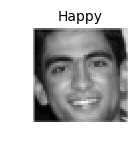

Found 4 faces!
1/1 [==============================] - 0s


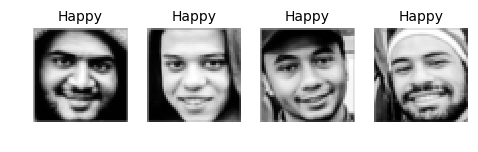

Found 2 faces!
1/1 [==============================] - 0s


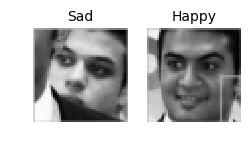

Found 3 faces!
1/1 [==============================] - 0s


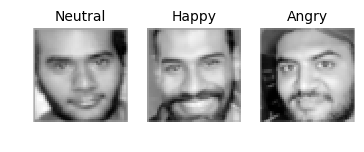

Found 4 faces!
1/1 [==============================] - 0s


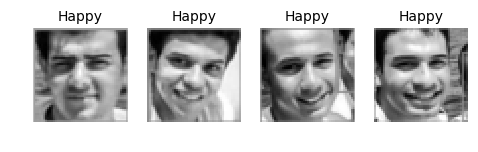

Found 46 faces!
1/1 [==============================] - 0s


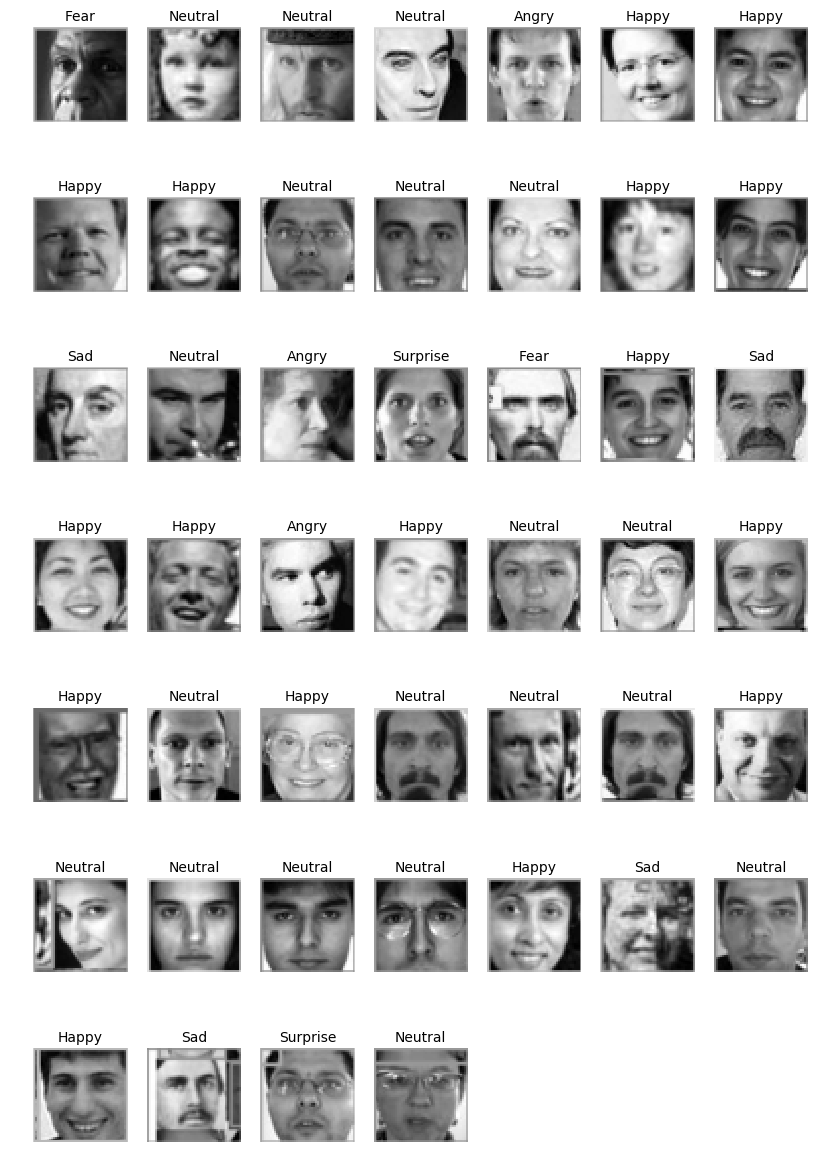

In [40]:
for j in range(1,7):
    img = cv2.imread(str(j)+'.jpg')
    faces = detect_faces(img)
    plt.figure(figsize=(10,15))
    for i in range(faces.shape[0]):
        plt.subplot(7,7,i+1)
        im = faces[i]
        im = rgb2gray(im)
        # print im.shape
        # im = np.transpose(im, (2,0,1))
        plt.imshow(im, cmap='gray', interpolation='none')
        output_eval = model.predict(im.reshape((1,1,IMAGE_HIGHT,IMAGE_WIDTH)), batch_size=BATCH_SIZE, verbose=1)
        #print emotions[np.argmax(output_eval)]
        #print np.argmax(output_eval) 
        #print 'Output: ',output_eval
        plt.title(emotions[np.argmax(output_eval)], fontsize=10)
        plt.axis('off')

    plt.show()

1/1 [==============================] - 0s


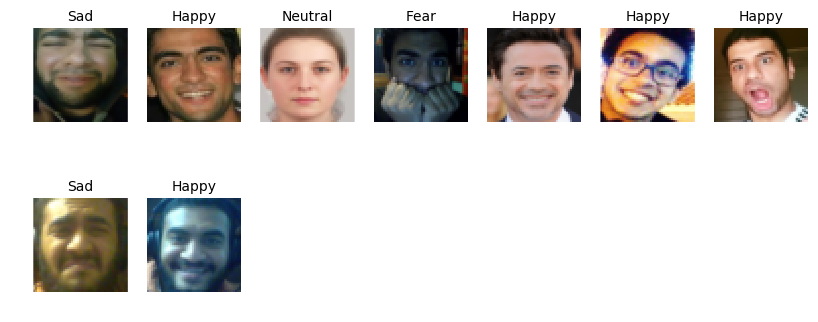

1/1 [==============================] - 0s


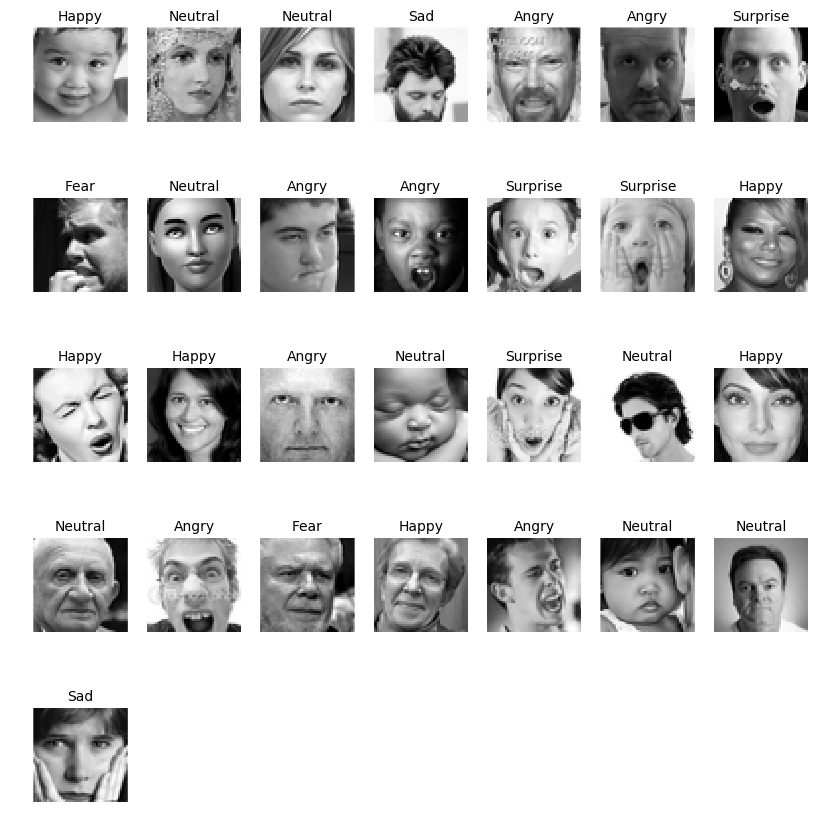

In [38]:
plt.figure(figsize=(10,15))
for i in range(1,10):
    plt.subplot(7,7,i)
    im = np.array(scipy.misc.imresize(plt.imread('test_images/{}.png'.format(i)),(IMAGE_HIGHT, IMAGE_WIDTH)))
    im1 = rgb2gray(im)
    plt.imshow(im, cmap='gray', interpolation='none')
    output_eval = model.predict(im1.reshape((1,1,IMAGE_HIGHT,IMAGE_WIDTH)), batch_size=BATCH_SIZE, verbose=1)
    #print emotions[np.argmax(output_eval)]
    #print np.argmax(output_eval) 
    #print 'Output: ',output_eval
    plt.title(emotions[np.argmax(output_eval)], fontsize=10)
    plt.axis('off')
    
plt.show()

plt.figure(figsize=(10,15))
for i in range(1,30):
    plt.subplot(7,7,i)
    offset = 20
    im1 = data['X_test'][i+offset][0]
    plt.imshow(im1, cmap='gray', interpolation='none')
    output_eval = model.predict(data['X_test'][i+offset].reshape((1,1,IMAGE_HIGHT,IMAGE_WIDTH)), batch_size=BATCH_SIZE, verbose=1)
    #print emotions[np.argmax(output_eval)]
    #print np.argmax(output_eval) 
    #print 'Output: ',output_eval
    #print 'Original: ',data['y_test'][i+offset]
    plt.title(emotions[np.argmax(output_eval)], fontsize=10)
    plt.axis('off')
    
plt.show()